In [16]:
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
data_yaml_path = 'Persian_Plates_Digits_YOLOV8_V2/data.yaml'
model = YOLO('yolov8n.pt')


results = model.train(data=data_yaml_path, epochs=50, imgsz=640)

print("نتایج آموزش:", results)
model.export(format='onnx')


0: 416x640 1 vehicle_number_plate, 126.7ms
Speed: 7.2ms preprocess, 126.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 192x640 1 4, 1 5, 1 7, 1 8, 3 9s, 1 M, 72.7ms
Speed: 1.4ms preprocess, 72.7ms inference, 1.2ms postprocess per image at shape (1, 3, 192, 640)
Recognized plate text: 47M59899


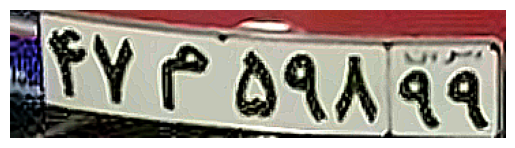

In [ ]:
weights_path = hf_hub_download(repo_id="krishnamishra8848/Nepal-Vehicle-License-Plate-Detection", filename="last.pt")
model_detection = YOLO(weights_path)

model_processing = YOLO('F:/my/code folder/plak prosesing/runs/detect/train5/weights/best.pt')

def process_image(image_path):
    image = Image.open(image_path)
    img = np.array(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    results_detection = model_detection(img)

    for result in results_detection:
        if hasattr(result, 'boxes') and result.boxes is not None:
            for box in result.boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)  
                plate_crop = img[y1:y2, x1:x2]


                scale_factor = 2 
                plate_upscaled = cv2.resize(
                    plate_crop, 
                    (plate_crop.shape[1]*scale_factor, plate_crop.shape[0]*scale_factor),
                    interpolation=cv2.INTER_CUBIC
                )

                plate_denoised = cv2.fastNlMeansDenoisingColored(
                    plate_upscaled, None,
                    h=10, hColor=10,
                    templateWindowSize=7, searchWindowSize=21
                )

                kernel_sharpening = np.array([
                    [-1, -1, -1],
                    [-1,  9, -1],
                    [-1, -1, -1]
                ])
                plate_sharpened = cv2.filter2D(plate_denoised, -1, kernel_sharpening)

                results_chars = model_processing.predict(source=plate_sharpened, conf=0.5)

                for r in results_chars:
                    if r.boxes is not None and len(r.boxes) > 0:
                        sorted_boxes = sorted(r.boxes, key=lambda b: b.xyxy[0][0])
                        
                        recognized_labels = []
                        for b in sorted_boxes:
                            class_id = int(b.cls[0])
                            label = r.names[class_id] 
                            recognized_labels.append(label)
                        recognized_text = "-".join(recognized_labels)
                        
                        print("Recognized plate text:", recognized_text)

                plt.imshow(cv2.cvtColor(plate_sharpened, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()

image_path = "test-images/6t.jpg" 
process_image(image_path)
